<a href="https://colab.research.google.com/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_subjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Across-subject testing with [GLHMM toolbox](https://github.com/vidaurre/glhmm)

This tutorial shows how to run the Across-subjects test using the [GLHMM toolbox](https://github.com/vidaurre/glhmm) described in [The Gaussian-Linear Hidden Markov Model: a Python Package](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python). 


This test is designed to compare two datasets across individuals. A common use case is to relate brain dynamics to behavioral measurements, but the method is flexible and can be applied to other types of data too.

In this example, we use a Gaussian HMM trained on synthetic resting-state-like fMRI data. Our goal is to see whether differences in brain state dynamics across individuals are linked to a behavioral variable.

* The brain data ($D$) contains summary statistics from the HMM such as fractional occupancy (FO).
* The behavioral data ($R$) includes one simulated variable


We use permutation testing to assess whether there is a significant relationship between $D$ and $R$.

**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_subjects.ipynb).

Authors: Nick Yao Larsen <nylarsen@cfin.au.dk>

## Table of Contents
1. [Preparation](#preparation)
2. [Load data](#load-data)
3. [Train or load pre-trained Gaussian HMM on fMRI data](#hmm-train)
    * [HMM-aggregated statistics](#hmm-agg)
2. [Across-subjects testing](#across_subjects)
    * [Across subjects - Multivariate](#perm_multivariate)
    * [Across subjects - Univariate](#perm_univariate)




# **1. Preparation** <a id="preparation"></a>

If you don't have the **GLHMM package** installed, this notebook will help you install it automatically.

We will also download example data from the Open Science Framework (OSF).

---


In [ ]:
# Install packages if needed
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab. Installing GLHMM...")
    !pip install git+https://github.com/vidaurre/glhmm

# Install osfclient if missing
try:
    import osfclient
except ImportError:
    print("Installing osfclient...")
    !pip install osfclient

# Now import everything we need
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from glhmm import glhmm, preproc, io, graphics, statistics
np.random.seed(0)  # For reproducibility

# **2. Load data** <a id="load-data"></a>
To get started, we’ll download the example data needed for this tutorial. These files include simulated fMRI time series, pre-trained HMM outputs, and subject-level variables like behavioral scores and confounds.
If they already exist, we will skip downloading.

We’ll use the `osfclient` package to fetch the files directly from the Open Science Framework (OSF). If you prefer, you can also download them manually from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666).

In [2]:
# Set up data directory
data_dir = Path.cwd() / "files" / "data_statistical_testing"

if not data_dir.exists():
    print(f"Creating {data_dir}...")
    data_dir.mkdir(parents=True, exist_ok=True)
else:
    print(f"Data directory {data_dir} already exists.")

# Files to download
files = [
    "tc_forpred.csv",
    "T_forpred.csv",
    "Y_forpred.csv",
    "confounds_forpred.csv",
    "hmm_pred.pkl"
]

# Download the files from OSF if they don't exist locally
for fname in files:
    local_path = data_dir / fname
    remote_path = f"Prediction/{fname}"

    if local_path.exists():
        print(f"✓ {fname} already exists — skipping.")
    else:
        print(f"Downloading {fname}...")
        # as_posix() ensures forward slashes on Windows for shell compatibility
        !osf -p 8qcyj fetch {remote_path} {local_path.as_posix()}


Data directory c:\Users\au323479\Github\glhmm_28_04\docs\notebooks\files\data_statistical_testing already exists.
✓ tc_forpred.csv already exists — skipping.
✓ T_forpred.csv already exists — skipping.
✓ Y_forpred.csv already exists — skipping.
✓ confounds_forpred.csv already exists — skipping.
✓ hmm_pred.pkl already exists — skipping.


**Load and check the data**\
The folder `data_statistical_testing` contains:

- **`data_raw`**: simulated resting-state-like fMRI time series  
  Shape **(n_timepoints × n_subjects, n_parcellations)** : **480,000 × 50** — where 480,000 = 4800 timepoints × 100 subjects  
  Each row is a timepoint; each column corresponds to one of 50 parcellations

- **`data_behav`**: simulated behavioral value  
  Shape **(n_subjects,)**: 1D array with one value for each of 100 subjects

- **`data_confounds`**: one confounding variable per subject  
  Shape **(n_subjects,)**: 1D array with one value for each of 100 subjects

- **`idx_time`**: session boundaries  
  Shape **(n_subjects, 2)**: 2D array with 10 rows — each row defines the start and end index for a subjects



> **Note**: For details on training from scratch, follow the tutorials [*Standard Gaussian Hidden Markov Model*](./GLHMM_example.ipynb) or [*Gaussian-Linear Hidden Markov Model*](./GLHMM_example.ipynb). In this notebook, we use precomputed Gamma values to focus on the across-sessions statistical test.

These data allow us to examine how brain state dynamics relate to behavioral responses across repeated sessions for the same subject.


Load the data into memory

In [3]:
# Load data from csv files and convert to numpy arrays
data_raw = pd.read_csv(data_dir / 'tc_forpred.csv', header=None).to_numpy()
idx_time = pd.read_csv(data_dir / 'T_forpred.csv', header=None).to_numpy()
data_behav = np.squeeze(pd.read_csv(data_dir / 'Y_forpred.csv', header=None).to_numpy())
data_confounds = np.squeeze(pd.read_csv(data_dir / 'confounds_forpred.csv', header=None).to_numpy())

**Check the shape of each dataset**

This step helps confirm that all files loaded correctly and match the expected dimensions.

In [4]:
# Check that dimensions are correct
print("data_raw:", data_raw.shape)         # should be (n_subjects*n_timepoints, n_parcels)
print("data_behav:", data_behav.shape)     # should be (n_subjects,) or (n_subjects, 1)
print("idx_time:", idx_time.shape)         # should be (n_subjects, 2)
print("data_confounds:", data_confounds.shape) # should be (n_subjects,) or (n_subjects, n_confounds)

data_raw: (480000, 50)
data_behav: (100,)
idx_time: (100, 2)
data_confounds: (100,)


**Standardise the time series**\
Before we move on to modelling or testing, it's important to standardise the time series. This step helps reduce noise and removes differences in signal amplitude across subjects that could affect the analysis.

We apply subject-wise standardisation using the preprocess_data function.

In [7]:
data_preproc, _, _= preproc.preprocess_data(data_raw, idx_time)

**Visualise before and after standardisation**\
Let’s take a quick look at the effect of standardisation on one subject's data. In this example, the original time series are already close to standardised, so the difference will be subtle. But for real datasets, this step is essential.

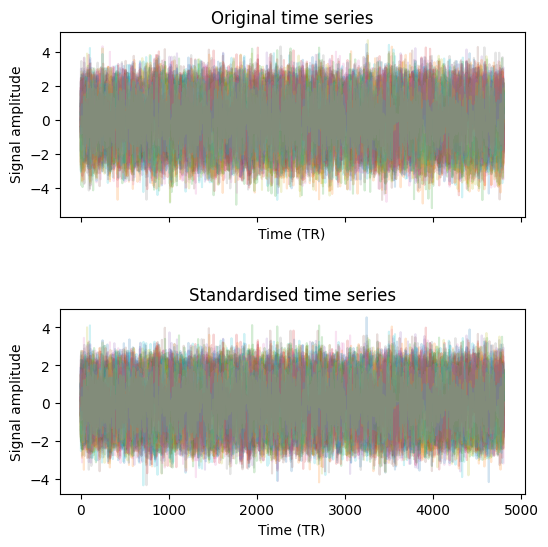

In [10]:
# Plot time series before and after standardisation for one subject
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))

ax0.plot(data_raw[0:4800, :], alpha=0.2)
ax0.set_xlabel("Time (TR)")
ax0.set_ylabel("Signal amplitude")
ax0.set_title("Original time series")

ax1.plot(data_preproc[0:4800, :], alpha=0.2)
ax1.set_xlabel("Time (TR)")
ax1.set_ylabel("Signal amplitude")
ax1.set_title("Standardised time series")

plt.subplots_adjust(hspace=0.5)
plt.show()


## **3. Train or load pre-trained Gaussian HMM on fMRI data** <a id="hmm-train"></a>

In this step, we load a pre-trained HMM that was fitted to the time series from all subjects. The model uses a Gaussian observation model with full covariance and includes six hidden states.

> **Note**: For details on training from scratch, follow the tutorials [*Standard Gaussian Hidden Markov Model*](./GLHMM_example.ipynb) or [*Gaussian-Linear Hidden Markov Model*](./GLHMM_example.ipynb). In this notebook, we use Gamma values decoded from a HMM model to focus on the across-subjects testing.

In [12]:
hmm = io.load_hmm(data_dir / 'hmm_pred.pkl')

**Decode state probabilities**\
We now decode the state probabilities (`Gamma`) for each subject using the standardised time series.

In [13]:
# Decode Gamma (state probabilities)
Gamma, _, _ = hmm.decode(X=None, Y=data_preproc, indices=idx_time)

### **HMM-aggregated statistics** <a id="hmm-agg"></a>
Fractional occupancy (FO) measures the proportion of time each subject spends in each state.

In [14]:
FO = glhmm.utils.get_FO(Gamma, idx_time)

print("FO shape:", FO.shape)
print("Behavioral data shape:", data_behav.shape)


FO shape: (100, 6)
Behavioral data shape: (100,)


**Visualise fractional occupancy**\
This plot shows the FO for each subject across the six states.

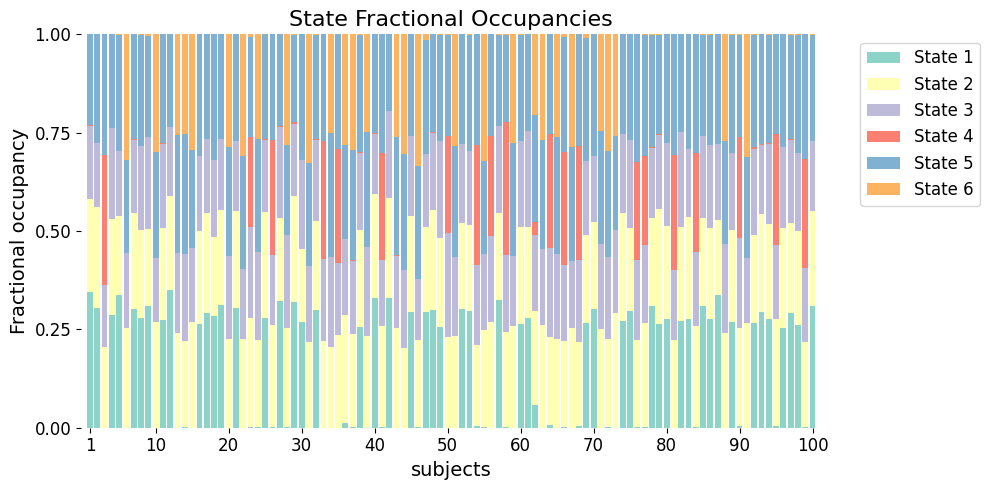

In [15]:
graphics.plot_FO(FO, xlabel="subjects", figsize=(10, 5))

This gives us a subject-by-state matrix that we’ll use in the next step to test for associations with behavioral measurements.

# **4. Across-subjects testing** <a id="across_subjects"></a>

Now that we have prepared our data across individuals, we’re ready to test whether brain dynamics (FO) are linked to behavioral differences across subjects using the across_subjects function.

Before we dive into the test, let’s quickly explain the idea.

In this type of test, we want to see if people with different behavioral characteristics (e.g., age, reaction times) also show differences in their brain state measures. For example, does a subject’s fractional occupancy of certain brain states relate to their behavioral scores?

To answer that, we use permutation testing. This approach creates a null distribution by randomly shuffling subject labels. If the results from the original (unshuffled) data are clearly different from what we see under the shuffled scenarios, it suggests that there is a real relationship between brain dynamics and behavior.

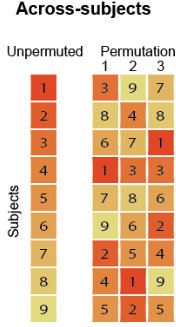

Figure 5A: Example of permutation across subjects. Each row is one subject. The first column shows the original ordering. Other columns show permutations.

## **Across subjects – Multivariate** <a id="perm_multivariate"></a>
The multivariate test looks at all FO values together to see if they jointly explain variation in the behavioral variable.

* `D_data`: fractional occupancies (subjects, states)

* `R_data`: behavioral variable (subjects,)

* `confounds`: optional, used to regress out effects of other variables

Settings:

* `method`: apply a `multivariate` regression test across states
* `Nnull_samples`: number of permutations to build the null distribution

Set up and run the test

In [74]:
# Setting up the parameters for the across-subjects test
method = "multivariate" # Method for testing (default = "multivariate")
Nnull_samples = 10_000 # Number of permutations (default = 0)

# Perform across-subject testing
result_multivariate  =statistics.test_across_subjects(D_data=FO, 
                                                      R_data=data_behav, 
                                                      method=method,
                                                      Nnull_samples=Nnull_samples,
                                                      )

Total possible permutations: 2.84e+35659
Running number of permutations: 10000


100%|██████████| 10000/10000 [00:02<00:00, 3934.80it/s]


**Understanding the output**

The result is stored in a dictionary called `result_multivariate`. Here's what it contains:

* ```pval```: array of p-values with shape (1, q). Each value corresponds to a behavioral variable. See the [GLHMM paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python) for details.

* ```base_statistics```: test statistics for the unpermuted data. For multivariate tests, this is the F-statistic

* ```null_stat_distribution```: array of test statistics computed from each permutation

* ```statistical_measures```: dictionary showing which statistic was used (e.g. F-stat)

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_subjects```.

* ```method```:  test method used, here it is `"multivariate"`

* ```max_correction```: whether MaxT correction was applied during permutation

* ```Nnull_samples```: number of permutations used to generate the null

* ```test_summary```: structured summary of results including F-test and model coefficients


**Display the test summary**

We can print a clean summary of the result using the helper function below.

In [54]:
statistics.display_test_summary(result_multivariate)


Model Summary:
    Outcome  F-stat  df1  df2  p-value (F-stat)
Regressor 1 15.4278    6   94               0.0

Coefficients Table:
Predictor     Outcome    T-stat  p-value      LLCI     ULCI
  State 1 Regressor 1 -4.934702   0.0000 -1.956605 1.954004
  State 2 Regressor 1  0.771663   0.4314 -1.979872 1.963015
  State 3 Regressor 1 -0.076354   0.9390 -1.963835 2.002302
  State 4 Regressor 1 -2.469949   0.0146 -1.954778 2.032965
  State 5 Regressor 1  0.557554   0.5682 -2.020788 1.965015
  State 6 Regressor 1  9.661851   0.0000 -1.988874 1.991025


This shows the overall test result and the contribution of each state. 

**Visualisation of results**\
After running the multivariate test, we can visualise the results using a simple bar plot of p-values.
We will use the function ```plot_p_values_bar``` from the ```graphics``` module 
> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.

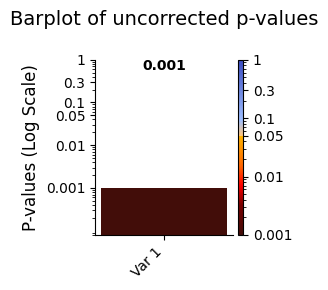

In [55]:
# Plot p-values
graphics.plot_p_values_bar(result_multivariate["pval"], 
                           title_text ="Barplot of uncorrected p-values",
                      figsize=(3, 3), alpha=0.05)

This shows the overall result and the contribution of each state when modelled together.

## **Across subjects – Univariate**  <a id="perm_univariate"></a>
This version tests each state individually. It assesses whether variation in a single state's FO across subjects explains the behavioral variable.

Each test is run separately and produces one p-value per state. This allows for identifying specific states that show a strong effect.

* `D_data`: fractional occupancies (subjects, states)

* `R_data`: behavioral variable (subjects,)

* `confounds`: optional, used to regress out effects of other variables

Settings:

* `method`: apply a `univariate` test across states (run one test per state)
* `Nnull_samples`: number of permutations to build the null distribution

Run the univariate test

In [71]:
# Set the parameters for between-subject testing
method = "univariate"
Nnull_samples = 10_000 # Number of permutations (default = 0)
# Perform across-subject testing
result_univariate  =statistics.test_across_subjects(D_data=FO, 
                                                    R_data=data_behav, 
                                                    method=method,
                                                    Nnull_samples=Nnull_samples,)


Total possible permutations: 2.84e+35659
Running number of permutations: 10000


100%|██████████| 10000/10000 [00:01<00:00, 8130.00it/s]


**Display the result**\
We can print a detailed summary of the test output.

In [73]:
statistics.display_test_summary(result_univariate)


Model Summary:
              Unit  Nnull_samples
t_stat_independent          10000

Coefficients Table:
Predictor     Outcome  Base Statistic  P-value
  State 1 Regressor 1       -4.934702   0.0001
  State 2 Regressor 1        0.771663   0.4408
  State 3 Regressor 1       -0.076354   0.9421
  State 4 Regressor 1       -2.469949   0.0154
  State 5 Regressor 1        0.557554   0.5823
  State 6 Regressor 1        9.661851   0.0001


This shows the t-statistic and p-value for each state.\
A low p-value suggests that `FO` in that state is related to the behavioral variable.

**Visualisation of results**\
To get a quick view of the results across all states:
Again, we use `plot_p_values_bar` to display the uncorrected p-values. 

If you have more than one behavioral variable, use `plot_p_value_matrix` instead.

> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.


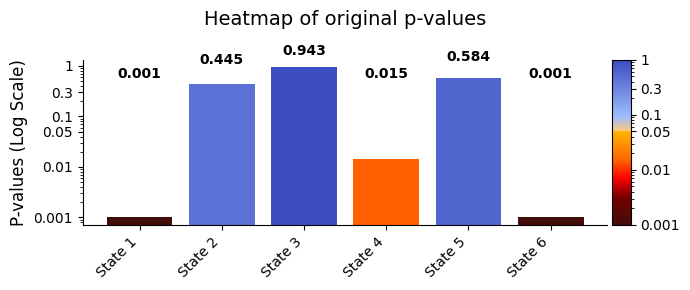

In [57]:
# Plot p-values
graphics.plot_p_values_bar(result_univariate["pval"].T, 
                           title_text ="Heatmap of original p-values",
                            figsize=(7, 3), 
                            xticklabels="State"
                            )

**Multiple testing correction**

To account for multiple comparisons, we use the Benjamini-Hochberg procedure:

In [77]:
pval_corrected, rejected_corrected = statistics.pval_correction(
    result_univariate,
    method="fdr_bh"
)

Plot the corrected results:

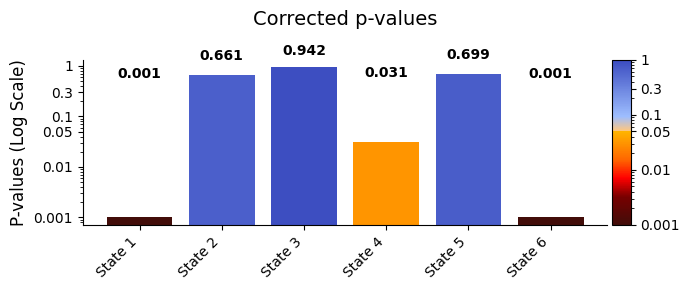

In [79]:
# Plot p-values
graphics.plot_p_values_bar(pval_corrected, 
                           title_text ="Corrected p-values",
                            figsize=(7, 3), xticklabels="State"
                            )

**Plot permutation distributions**\
These plots show the distribution of test statistics under the null for each state. The red line marks the observed value.

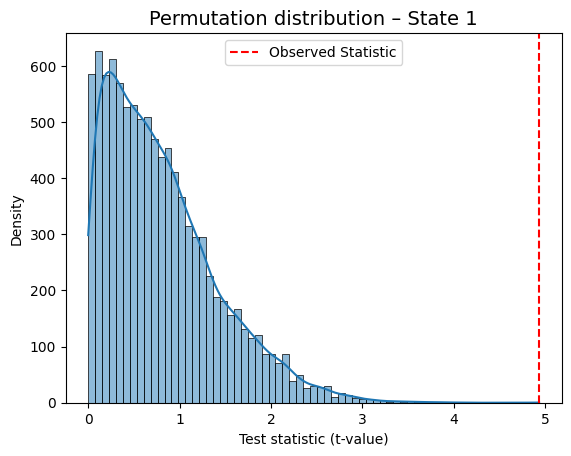

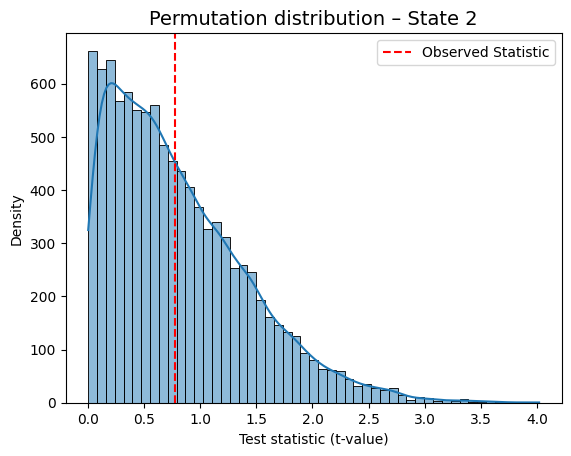

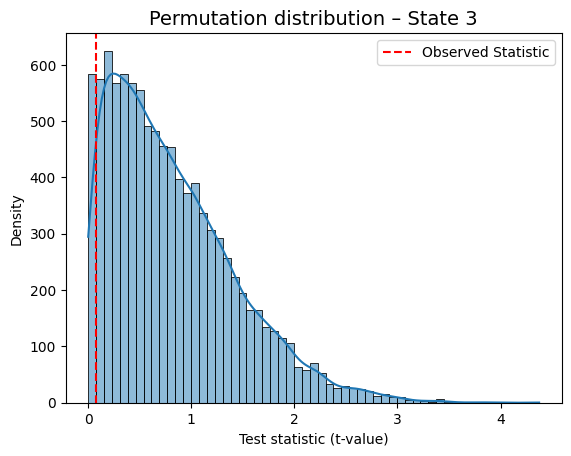

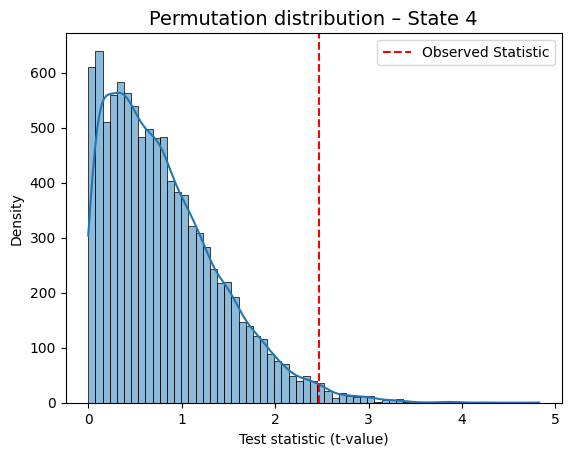

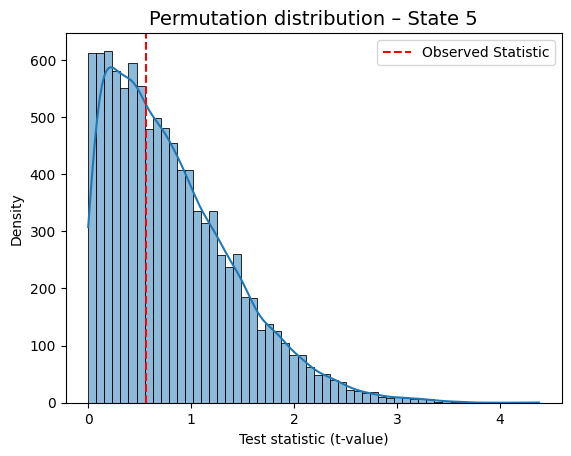

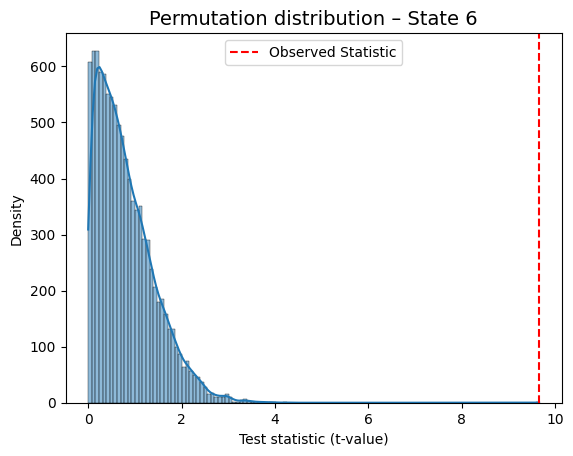

In [83]:
xlabel = "Test statistic (t-value)"

for i in range(result_univariate["null_stat_distribution"].shape[1]):
    graphics.plot_permutation_distribution(
        result_univariate["null_stat_distribution"][:, i],
        title_text=f"Permutation distribution – State {i+1}",
        xlabel=xlabel
    )


This is a helpful way to visually confirm which states show a meaningful association with the behavioral variable.